### This notebook is an investigation about finalize_model() from TS Pycaret: parameters changing

References
- https://pycaret.readthedocs.io/en/time_series/api/time_series.html
- https://towardsdatascience.com/announcing-pycarets-new-time-series-module-b6e724d4636c
- https://github.com/pycaret/pycaret/discussions/1767
- https://github.com/pycaret/pycaret/discussions/1795
- https://github.com/pycaret/pycaret/discussions/1969

In [4]:
import pandas as pd
import numpy as np
from pycaret.time_series import *

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

<AxesSubplot:xlabel='Period'>

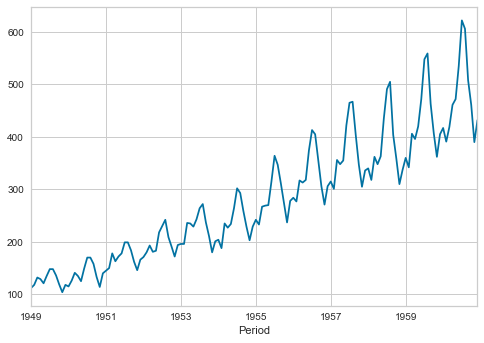

In [5]:
### exemplo de dados mensais
from pycaret.datasets import get_data
data = get_data('airline', verbose=True)
data.plot()

In [6]:
n_frequecia = 12


setup(data, 
      fh = 6, ### fh aqui define o tamanho do teste/validação
      fold = 3, ## quebra a amostra de treino. Poderia seria igual 2, porém se não for >=3, quebra o tunning (qto > fold => menor amostra para treino)
      fold_strategy='sliding',
      enforce_pi=False, ### somente prophet, arima, ets e tabts têm intervalos de projeçõa, se True, vai trazer somente esses métodos
      seasonal_period=n_frequecia,
      #profile=True,
      preprocess=True, ### não está funcionando ainda
      session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(144, 1)"
2,Missing Values,False
3,Transformed Train Set,"(138,)"
4,Transformed Test Set,"(6,)"
5,Fold Generator,SlidingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,12
9,Seasonality Detected,True


### Using sktime for auto.arima

In [8]:
from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
y = get_config('y_train') ## only in the train portion
forecaster = AutoARIMA(sp=12, suppress_warnings=True,random_state=123)
z=forecaster.fit(y)
AutoARIMA(...)
y_pred = forecaster.predict(fh=[1,2,3,4,5,6])

In [9]:
z.get_params()

{'D': None,
 'alpha': 0.05,
 'd': None,
 'error_action': 'warn',
 'information_criterion': 'aic',
 'max_D': 1,
 'max_P': 2,
 'max_Q': 2,
 'max_d': 2,
 'max_order': 5,
 'max_p': 5,
 'max_q': 5,
 'maxiter': 50,
 'method': 'lbfgs',
 'n_fits': 10,
 'n_jobs': 1,
 'offset_test_args': None,
 'out_of_sample_size': 0,
 'random': False,
 'random_state': 123,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal': True,
 'seasonal_test': 'ocsb',
 'seasonal_test_args': None,
 'sp': 12,
 'start_P': 1,
 'start_Q': 1,
 'start_p': 2,
 'start_params': None,
 'start_q': 2,
 'stationary': False,
 'stepwise': True,
 'suppress_warnings': True,
 'test': 'kpss',
 'trace': False,
 'trend': None,
 'with_intercept': True}

In [11]:
### model configuration and parameters for train
z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -476.916
Date:                                 Tue, 21 Dec 2021   AIC                            963.831
Time:                                         11:25:35   BIC                            977.973
Sample:                                              0   HQIC                           969.576
                                                 - 138                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4017      0.063     -6.333      0.000      -0.526      -0.277
ar.S.L12       0.9670      0.129      7.506      0.000       0.714       1.219
ma.S.L12      -1.2407      0.303     -4.100      0.000      -1.834      -0.648
ma.S.L24       0.3552      0.136      2.620      0.009       0.089       0.621
sigma2       111.8755     14.982      7.467      0.000      82.512     141.239
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
y_pred_semfit = forecaster.predict(fh=[1,2,3,4,5,6]) ## o cutoff 1960-06
y_pred_semfit

1960-07    609.332147
1960-08    621.380930
1960-09    516.993948
1960-10    459.167589
1960-11    409.771084
1960-12    450.028823
Freq: M, dtype: float64

In [14]:
## using a function from stkime for not update_params, but to forecast using the holdout portion of the data set (appended)
y_pred = forecaster.update_predict_single(y_new=get_config('y_test'), update_params=False)
y_pred
### dates changed, but forecasted values are the same as above

1961-01    609.332147
1961-02    621.380930
1961-03    516.993948
1961-04    459.167589
1961-05    409.771084
1961-06    450.028823
Freq: M, dtype: float64

In [15]:
### just changing the input of the function
y_pred = forecaster.update_predict_single(y=get_config('y'), update_params=False)
y_pred

1961-01    609.332147
1961-02    621.380930
1961-03    516.993948
1961-04    459.167589
1961-05    409.771084
1961-06    450.028823
Freq: M, dtype: float64

In [16]:
### another function from stkime, without update/retrain model parameters
updated_model =  forecaster.update(y=get_config('y'), update_params=False)
updated_model.predict()

1961-01    609.332147
1961-02    621.380930
1961-03    516.993948
1961-04    459.167589
1961-05    409.771084
1961-06    450.028823
Freq: M, dtype: float64

In [18]:
### however, if we set "update_params=True", time for command excution increase and forecasted values change
updated_model =  forecaster.update(y=get_config('y_test'), update_params=True)
updated_model.predict()

1961-01    451.347076
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
Freq: M, dtype: float64

In [19]:
## but model parameters/configuration are different
updated_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Tue, 21 Dec 2021   AIC                           1019.178
Time:                                     11:30:13   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
### using another function from Sktime, .fit_predict, the same results as above
y2=get_config('y')
y_pred = forecaster.fit_predict(y2,fh=[1,2,3,4,5,6])
y_pred

1961-01    451.347076
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
Freq: M, dtype: float64

##### Using  auto.arima from TS Pycaret

In [21]:
autoarima = create_model('auto_arima',cross_validation=False,random_state=123)
final_arima = finalize_model(autoarima)

,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,12.7792,14.1258,0.0266,0.0262,0.4073,0.973


In [22]:
###  predict withour finalize_model()
predict_model(autoarima) 

,Model,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,Auto ARIMA,12.7792,14.1258,0.0266,0.0262,0.4073,0.9730


1960-07    609.3321
1960-08    621.3809
1960-09    516.9939
1960-10    459.1676
1960-11    409.7711
1960-12    450.0288
Freq: M, Name: Number of airline passengers, dtype: float64

In [23]:
### modelo com finalize model
### mesmo resultado do anterior do sktime, quando se faz o retreino
predict_model(final_arima) 

1961-01    451.3471
1961-02    427.1022
1961-03    463.3825
1961-04    499.7058
1961-05    514.0355
1961-06    571.8519
Freq: M, Name: Number of airline passengers, dtype: float64

In [24]:
### amentando os n_steps, veja que fica diferente, e o valor alimentado é o proprio yhat anterior
predict_model(autoarima,fh=12)

1960-07    609.3321
1960-08    621.3809
1960-09    516.9939
1960-10    459.1676
1960-11    409.7711
1960-12    450.0288
1961-01    465.6640
1961-02    438.6528
1961-03    479.7779
1961-04    506.6883
1961-05    523.7018
1961-06    590.2737
Freq: M, Name: Number of airline passengers, dtype: float64

In [25]:
## by summary, we can see that models are different, retrained in 144 observations in the finalize_model()
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -476.916
Date:                                 Tue, 21 Dec 2021   AIC                            963.831
Time:                                         11:50:14   BIC                            977.973
Sample:                                              0   HQIC                           969.576
                                                 - 138                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4017      0.063     -6.333      0.000      -0.526      -0.277
ar.S.L12       0.9670      0.129      7.506      0.000       0.714       1.219
ma.S.L12      -1.2407      0.303     -4.100      0.000      -1.834      -0.648
ma.S.L24       0.3552      0.136      2.620      0.009       0.089       0.621
sigma2       111.8755     14.982      7.467      0.000      82.512     141.239
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# autoarima.get_params()
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -476.916
Date:                                 Tue, 21 Dec 2021   AIC                            963.831
Time:                                         11:50:16   BIC                            977.973
Sample:                                              0   HQIC                           969.576
                                                 - 138                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4017      0.063     -6.333      0.000      -0.526      -0.277
ar.S.L12       0.9670      0.129      7.506      0.000       0.714       1.219
ma.S.L12      -1.2407      0.303     -4.100      0.000      -1.834      -0.648
ma.S.L24       0.3552      0.136      2.620      0.009       0.089       0.621
sigma2       111.8755     14.982      7.467      0.000      82.512     141.239
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [523]:
final_arima.get_params()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 20 Dec 2021   AIC                           1019.178
Time:                                     17:05:39   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
## Let's tune autoarima
tuned_arima = tune_model(autoarima, n_iter=5, search_algorithm='random',
                         choose_better=True,
                         tuner_verbose=False,
                         optimize='MAE',
                         fold=1)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,1959-12,15.9038,19.8685,0.0355,0.0350,0.5223,0.8227
Mean,nan,15.9038,19.8685,0.0355,0.0350,0.5223,0.8227
SD,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [28]:
## it is the same model autoarima and z, from Sktime (same parameters and configuration)
tuned_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -476.916
Date:                                 Tue, 21 Dec 2021   AIC                            963.831
Time:                                         11:55:29   BIC                            977.973
Sample:                                              0   HQIC                           969.576
                                                 - 138                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4017      0.063     -6.333      0.000      -0.526      -0.277
ar.S.L12       0.9670      0.129      7.506      0.000       0.714       1.219
ma.S.L12      -1.2407      0.303     -4.100      0.000      -1.834      -0.648
ma.S.L24       0.3552      0.136      2.620      0.009       0.089       0.621
sigma2       111.8755     14.982      7.467      0.000      82.512     141.239
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.50
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
### when tunning "tuned_arima", results/parameters are diferent from above (autoarima and tuned_arima), but equal to final_arima
final_model_arima_tuned = finalize_model(tuned_arima)
final_model_arima_tuned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Tue, 21 Dec 2021   AIC                           1019.178
Time:                                     13:36:18   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
final_model_arima_tuned.predict()

1961-01    451.347076
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
Freq: M, dtype: float64

In [531]:
updated_model = final_model_arima_tuned.update(y=get_config('y_test'), update_params=False)
updated_model.predict()

1961-01    451.347076
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
Freq: M, dtype: float64